# NPZD slab model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc

In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra


from phydra.utility.xsimlabwrappers import phydra_setup

In [3]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, Time, make_Component
from phydra.processes.environments import BaseEnvironment, Slab
from phydra.processes.fluxes import BaseFlux, LimitedGrowth, LinearMortality, make_flux
from phydra.processes.forcingfluxes import Mixing, Sinking, Upwelling, make_FX_flux
from phydra.processes.forcing import SinusoidalMLD, ConstantN0
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [4]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [5]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.74.gac3e6c8.dirty


In [6]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N'), 'P':make_Component('Phytoplankton','P'),
    'Z':make_Component('Zooplankton','Z'), 'D':make_Component('Detritus','D'),
    'Env':Slab, 
    
    # Fluxes
    'P_Growth':make_flux(LimitedGrowth, 'G'), 
    'P_LinMortality':make_flux(LinearMortality, 'M'), 
    
    # ForcingFluxes
    'Sinking':make_FX_flux(Sinking, 'S'),
    'Upwelling':make_FX_flux(Upwelling, 'U'),
    
    'MLD':SinusoidalMLD, 
    'N0':ConstantN0, 
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (16 processes, 24 inputs)>
context
time
    days               [in] ('time',) time in days
grid
    shape              [in]
    length             [in]
ibcs
    ibc                [in] Initial Boundary Conditions
N
    init               [in]
    dim                [in]
P
    init               [in]
    dim                [in]
Z
    init               [in]
    dim                [in]
D
    init               [in]
    dim                [in]
P_Growth
    halfsat            [in] half-saturation constant of nutrient up...
    mu                 [in] Maximum growth rate of component
    R_label            [in] label of ressource component that is co...
    C_label            [in] label of component that grows
N0
    constant_N0        [in] value of the constant Nutrient forcing
MLD
Sinking
    C_labels           [in] s label of component(s) that grows
    kappa              [in] constant mixing coefficient
P_LinMortality
    R_label            [in] label of component that ex

In [7]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('D', 'D'),
 ('Env', 'components'),
 ('Env', 'fluxes'),
 ('Env', 'forcingfluxes'),
 ('P_Growth', 'G'),
 ('P_LinMortality', 'M'),
 ('Sinking', 'S'),
 ('Upwelling', 'U')]

In [8]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 365*3)), #365*
        
        'N':{'dim':1,'init':1}, 
        'P':{'dim':1,'init':.1},
        'Z':{'dim':1,'init':0},
        'D':{'dim':1,'init':0},
        
        'P_Growth':{'mu':1.,
               'R_label':'N',
               'C_label':'P', 
               'halfsat':0.5},
        
        'P_LinMortality':{'mortality_rate':0.1,
               'R_label':'P',
               'C_label':'D'},
        
        'Sinking':{'kappa':0.1,
               'C_labels':['D','P']},
        
        'Upwelling':{'kappa':0.1,
               'C_labels':['N']},
        
        'N0__constant_N0':2.
    },
    output_vars={
        'Env__comp_output':None,
        'Env__flux_output':None,
        'Env__fxflux_output':None
    }
                 )

In [9]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Gekko Context
Initializing Model Time
dimensions of component N are initialized at 1
Initializing component  N ['N']
FULLDIMS [[0.]]
[[1]]
dimensions of component P are initialized at 1
Initializing component  P ['P']
FULLDIMS [[0.]]
[[0.1]]
dimensions of component Z are initialized at 1
Initializing component  Z ['Z']
FULLDIMS [[0.]]
[[0]]
dimensions of component D are initialized at 1
Initializing component  D ['D']
FULLDIMS [[0.]]
[[0]]
flux P_Growth is initialized for N --> P
Initializing flux: P_Growth-N2P
forcing flux Sinking is initialized at ['D' 'P']
Initializing forcing flux Sinking for components ['D' 'P']
flux P_LinMortality is initialized for P --> D
Initializing flux: P_LinMortality-P2D
forcing flux Upwelling is initialized at ['N']
Initializing forcing flux Upwelling for components ['N']


Initializing Environment: 
 components:['N', 'P', 'Z', 'D'] 
 fluxes:['P_Growth-N-2-P', 'P_LinMortality-P-2-D'] 
 fx-fluxes:['Sinking-D', 'Sinking-P', 'Upwelling-N']


Ass

In [10]:
out_ds

<xarray.Dataset>
Dimensions:                         (D: 1, G: 1, M: 1, N: 1, P: 1, S: 2, U: 1, Z: 1, clock: 2, components: 4, fluxes: 2, forcingfluxes: 3, s: 2, time: 1095, u: 1)
Coordinates:
  * D                               (D) <U1 'D'
  * G                               (G) <U14 'P_Growth-N-2-P'
  * M                               (M) <U20 'P_LinMortality-P-2-D'
  * N                               (N) <U1 'N'
  * P                               (P) <U1 'P'
  * S                               (S) <U9 'Sinking-D' 'Sinking-P'
  * U                               (U) <U11 'Upwelling-N'
  * Z                               (Z) <U1 'Z'
  * clock                           (clock) int64 0 1
  * components                      (components) <U1 'N' 'P' 'Z' 'D'
  * fluxes                          (fluxes) <U20 'P_Growth-N-2-P' 'P_LinMortality-P-2-D'
  * forcingfluxes                   (forcingfluxes) <U11 'Sinking-D' ... 'Upwelling-N'
  * time                            (time) int64 0 1 2 3 ... 1091 1092 1093 1094
Dimensions without coordinates: s, u
Data variables:
    D__dim                          int64 1
    D__init                         int64 0
    Env__comp_output                (components, time) float64 1.0 ... 1.791
    Env__flux_output                (fluxes, time) float64 0.06667 ... 0.01496
    Env__fxflux_output              (forcingfluxes, time) float64 0.0 ... 0.01606
    N0__constant_N0                 float64 2.0
    N__dim                          int64 1
    N__init                         int64 1
    P_Growth__C_label               <U1 'P'
    P_Growth__R_label               <U1 'N'
    P_Growth__halfsat               float64 0.5
    P_Growth__mu                    float64 1.0
    P_LinMortality__C_label         <U1 'D'
    P_LinMortality__R_label         <U1 'P'
    P_LinMortality__mortality_rate  float64 0.1
    P__dim                          int64 1
    P__init                         float64 0.1
    Sinking__C_labels               (s) <U1 'D' 'P'
    Sinking__kappa                  float64 0.1
    Upwelling__C_labels             (u) <U1 'N'
    Upwelling__kappa                float64 0.1
    Z__dim                          int64 1
    Z__init                         int64 0
    grid__length                    int64 1
    grid__shape                     int64 1
    ibcs__ibc                       float64 nan
    time__days                      (time) int64 0 1 2 3 ... 1091 1092 1093 1094

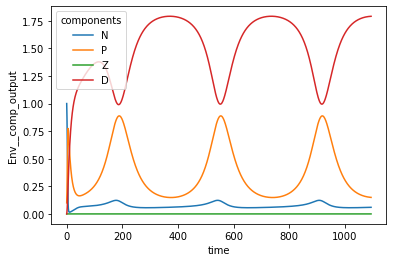

In [11]:
out_ds.Env__comp_output.plot.line(x='time')

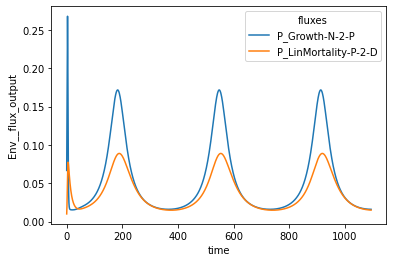

In [12]:
out_ds.Env__flux_output.plot.line(x='time')

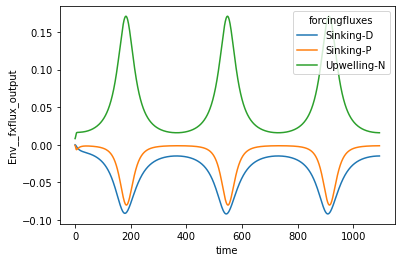

In [13]:
out_ds.Env__fxflux_output.plot.line(x='time')